### Imports

In [62]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F
import torch.nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

### Reading the Dataset

In [63]:
data = pd.read_csv("nasdaq100_padding.csv")

In [64]:
data.shape

(40560, 82)

In [65]:
data.head(1)

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,AMZN,ATVI,AVGO,BBBY,BIDU,BIIB,CA,CELG,CERN,CMCSA,COST,CSCO,CSX,CTRP,CTSH,DISCA,DISH,DLTR,EA,EBAY,ESRX,EXPE,FAST,FB,FOX,FOXA,GILD,GOOGL,INTC,JD,...,LBTYK,LRCX,MAR,MAT,MCHP,MDLZ,MSFT,MU,MXIM,MYL,NCLH,NFLX,NTAP,NVDA,NXPI,PAYX,PCAR,PYPL,QCOM,QVCA,ROST,SBUX,SIRI,STX,SWKS,SYMC,TMUS,TRIP,TSCO,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.98,96.8,97.8,61.15,95.4,58.18,58.0,127.04,26.68,165.81,742.12,42.3,161.41,44.21,159.89,286.32,34.57,106.05,62.07,67.34,167.6,30.79,28.37,43.52,58.4,25.42,52.44,96.55,76.95,30.6,76.54,117.88,41.99,121.94,27.5,26.86,84.0,756.57,34.77,21.8,...,30.21,91.24,71.11,32.78,54.78,45.69,56.515,14.0,39.2,47.13,41.9,91.0,26.44,56.1984,85.23,60.74,56.17,37.77,60.95,26.74,61.13,58.579,4.28,31.35,65.36,20.37,44.95,70.05,91.41,227.65,70.73,45.23,31.1701,95.27,81.365,52.16,33.95,48.61,38.01,4665.054


### Data Preprocessing

In [66]:
#Window size to consider number of historical values and no of timesteps to consider among the total data
T = 11
timesteps=16

In [67]:
X = np.zeros((len(data), timesteps, 81))
y = np.zeros((len(data), timesteps, 1))

##### Filling out null values and shifting them accordingly

In [68]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(16 - j - 1).fillna(method="bfill")

In [69]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(16 - j - 1).fillna(method="bfill")

In [70]:
no_of_target_val = 1
target = data["NDX"].shift(-no_of_target_val).fillna(method="ffill").values

##### Getting the values based on the timesteps

In [71]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [72]:
target.shape

(40544,)

In [73]:
target

array([4677.582, 4677.685, 4680.184, ..., 4922.949, 4922.942, 4922.942])

In [74]:
X.shape

(40544, 16, 81)

In [75]:
y.shape

(40544, 16, 1)

##### Slitting the data into train, validation and test set

In [76]:
X_train = X[:35100]
y_train = y[:35100]
X_val = X[35100:37830]
y_val = y[35100:37830]
X_test = X[37830:]
y_test = y[37830:]
target_train = target[:35100]
target_val = target[35100:37830]
target_test = target[37830:]

##### Normalizing the data

In [77]:
max_target = target_train.max(axis=0)
min_target = target_train.min(axis=0)

In [78]:
def normalize_data(x):
    min_v = x.min(axis=0)
    max_v = x.max(axis=0)

    norm_val = (x - min_v) / (max_v - min_v)
    norm_val = norm_val.astype(np.float32)
    norm_val = torch.tensor(norm_val)
    return norm_val


In [79]:
X_train = normalize_data(X_train)
X_val = normalize_data(X_val)
X_test = normalize_data(X_test)

In [80]:
y_train = normalize_data(y_train)
y_val = normalize_data(y_val)
y_test = normalize_data(y_test)

In [81]:
target_train = normalize_data(target_train) 
target_val = normalize_data(target_val)
target_test = normalize_data(target_test)

##### Model Architecture

In [82]:
class Encoder(nn.Module):
    def __init__(self, inputfeatures, outputfeatures, hidden_units=32, network_depth=3, carrygate=True):
        super(Encoder, self).__init__()
        self.inputfeatures = inputfeatures
        self.network_depth = network_depth
        self.hidden_units = hidden_units
        self.carrygate = carrygate

## Defining hidden and layers of Highway Netowrks        
        self.hiddenlayer_g = nn.Linear(inputfeatures, hidden_units, bias=False)
        self.hiddenlayer_T = nn.Linear(inputfeatures, hidden_units, bias=False)
        if not carrygate:
            self.hiddenlayer_c = nn.Linear(inputfeatures, hidden_units, bias=False)
        self.RHN_g = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for k in range(network_depth)])
        self.RHN_T = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for k in range(network_depth)])
        if not carrygate:
            self.RHN_c = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for k in range(network_depth)])


    def forward(self, x):
        s = torch.zeros(x.shape[0], self.hidden_units).cuda()
        pred_stack = []
        highway_states = []
        for t in range(x.shape[1]):

            x_inp = x[:, t, :]

            pred_stack = []
            for k in range(self.network_depth):
                if k == 0:
                    g = torch.tanh(self.hiddenlayer_g(x_inp) + self.RHN_g[k](s))
                    r = torch.sigmoid(self.hiddenlayer_T(x_inp) + self.RHN_T[k](s))
                    if not self.carrygate:
                        c = torch.sigmoid(self.hiddenlayer_c(x_inp) + self.RHN_c[k](s))
                else:
                    g = torch.tanh(self.RHN_g[k](s))
                    r = torch.sigmoid(self.RHN_T[k](s))
                    if not self.carrygate:
                        c = torch.sigmoid(self.RHN_c[k](s))

                if not self.carrygate:
                    s = g*r + c*s
                else:
                    s = g*r + (1 - r)*s
                pred_stack.append(s)
            all_s = torch.stack(pred_stack)


            pred_stack.append(s)
            highway_states.append(all_s)
        pred_stack = torch.stack(pred_stack)
        pred_stack = pred_stack.permute(1, 0, 2)
        highway_states = torch.stack(highway_states)
        highway_states = highway_states.permute(2, 0, 3, 1)
        op = pred_stack

        return op, highway_states

        
### Defining the convolution block for the architecture
class Convolution_Blocks(nn.Module):
    def __init__(self, T, in_channels, filters=32, filter_size=5):
        super(Convolution_Blocks, self).__init__()
        self.conv = Convolution_Blocks._conv( in_channels, filters, filter_size, padding=2)
        self.relu = Convolution_Blocks._relu()
        self.maxpool = Convolution_Blocks._pooling(T)
        
    @staticmethod
    def _conv(in_channels , filters, filter_size, padding = None ):

        return nn.Conv1d(in_channels, filters, filter_size, padding=2)

    @staticmethod
    def _relu():

        return nn.ReLU()

    @staticmethod
    def _pooling(T):
        return  nn.AdaptiveMaxPool1d(T)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        return x


class Decoder(nn.Module):
    def __init__(self, n_conv_layers, T, inputfeatures, target_feats, hidden_units_enc=32, hidden_units_dec=32, enc_input_size=32, network_depth=3,
                 outputfeatures=1, filters=32, filter_size=5):
        super(Decoder, self).__init__()
        self.n_convs = n_conv_layers
        self.hidden_units_enc = hidden_units_enc
        self.hidden_units_dec = hidden_units_dec
        self.network_depth = network_depth
        self.T = T #window size
        self.convs = Decoder.__convs(T, inputfeatures, filters=filters, filter_size=filter_size , n_convs = self.n_convs) 
        self.conv_to_enc = nn.Linear(filters, enc_input_size)
        self.Encoder = Encoder(enc_input_size, outputfeatures=hidden_units_enc, hidden_units=hidden_units_enc, network_depth=network_depth)
        self.inputfeatures = target_feats
        self.hidden_units = hidden_units_dec
        self.carrygate = True

        self.hiddenlayer_g = nn.Linear(self.inputfeatures, self.hidden_units, bias=False)
        self.hiddenlayer_T = nn.Linear(self.inputfeatures, self.hidden_units, bias=False)
        if not self.carrygate:
            self.hiddenlayer_c = nn.Linear(self.inputfeatures, self.hidden_units, bias=False)
        self.RHN_g = nn.ModuleList([nn.Linear(self.hidden_units, self.hidden_units) for k in range(network_depth)])
        self.RHN_T = nn.ModuleList([nn.Linear(self.hidden_units, self.hidden_units) for k in range(network_depth)])
        if not self.carrygate:
            self.RHN_c = nn.ModuleList([nn.Linear(self.hidden_units, self.hidden_units) for k in range(network_depth)])

        self.param_Tk = Decoder.__linear_layers(hidden_units_dec, hidden_units_enc, bias=False , network_depth = self.network_depth) 
        self.param_Uk = Decoder.__linear_layers(hidden_units_enc, hidden_units_enc , network_depth = self.network_depth)
        self.param_vk = Decoder.__linear_layers(hidden_units_enc, 1 , network_depth = self.network_depth)

        self.allW = nn.Linear(target_feats, target_feats, bias=False)
        self.allV = nn.Linear(network_depth*hidden_units_enc, target_feats)
        self.Wfinal = nn.Linear(hidden_units_dec, target_feats)
        self.Vfinal = nn.Linear(network_depth*hidden_units_enc, target_feats)


    @staticmethod
    def __convs( T, inputfeatures, filters=32, filter_size=5 , n_convs = None ):

        return nn.ModuleList([Convolution_Blocks(T, inputfeatures, filters=filters, filter_size=filter_size) if k == 0 else Convolution_Blocks(T, filters, filters=filters, filter_size=filter_size) for k in range(n_convs)])

    @staticmethod
    def __linear_layers(hidden_units_dec, hidden_units_enc, bias=True , network_depth=3):

        return nn.ModuleList([nn.Linear(hidden_units_dec, hidden_units_enc, bias=bias) for k in range(network_depth)])


    def forward(self, x, y):
        for l in range(self.n_convs):
            x = self.convs[l](x)
        x = self.conv_to_enc(x)
        x, highway_states = self.Encoder(x) 
        s = torch.zeros(x.shape[0], self.hidden_units_dec).cuda()

        for t in range(self.T):
            s_prev = s.unsqueeze(1)
            s_prev = s_prev.repeat(1, self.T, 1)
            d_t = []
            for k in range(self.network_depth):
                hidden_states = highway_states[..., k]
                e = self.param_vk[k](torch.tanh(self.param_Tk[k](s_prev) + self.param_Uk[k](hidden_states)))            
                attention_W_alpha = torch.softmax(e, 1)
                d_t_temp = torch.sum(hidden_states*attention_W_alpha, dim=1)
                d_t.append(d_t_temp)
            d_t = torch.cat(d_t, dim=1)
            Y_all = self.allW(y[:, t, :]) + self.allV(d_t)
            
            pred_stack= []
            for k in range(self.network_depth):
                if k == 0:
                    g = torch.tanh(self.hiddenlayer_g(Y_all) + self.RHN_g[k](s))
                    r = torch.sigmoid(self.hiddenlayer_T(Y_all) + self.RHN_T[k](s))
                    if not self.carrygate:
                        c = torch.sigmoid(self.hiddenlayer_c(Y_all) + self.RHN_c[k](s))
                else:
                    g = torch.tanh(self.RHN_g[k](s))
                    r = torch.sigmoid(self.RHN_T[k](s))
                    if not self.carrygate:
                        c = torch.sigmoid(self.RHN_c[k](s))

                if not self.carrygate:
                    s = g*r + c*s
                else:
                    s = g*r + (1 - r)*s
                pred_stack.append(s)
            pred_stack = torch.stack(pred_stack)



        Y_T = self.Wfinal(s) + self.Vfinal(d_t)
        return Y_T




##### Initialzing the model parameters and optimizers

In [83]:
model = Decoder(3, 16, 81, 1, hidden_units_enc=64, hidden_units_dec=64).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

#### Using Dataloader to load data for training and testing

In [85]:
data_train_loader = DataLoader(TensorDataset(X_train, y_train, target_train), shuffle=True,batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val, y_val, target_val), shuffle=False,batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test, y_test, target_test), shuffle=False,batch_size=64)

#### Training the model

Iter:  0 train:  0.12322486388338254 val:  0.08233800983744549
Rmse:  21.60113 mae:  17.809464


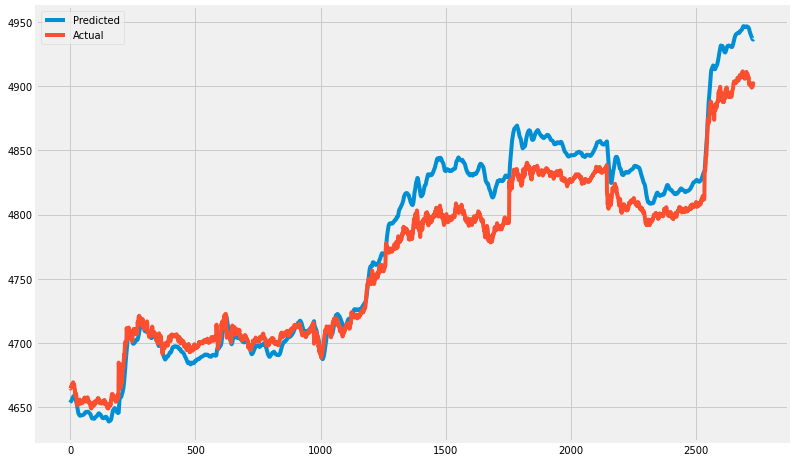

Iter:  1 train:  0.01919840012364521 val:  0.08929151761251869
Iter:  2 train:  0.017097418988994546 val:  0.0562972247377725
Iter:  3 train:  0.013062032160671531 val:  0.04265298128409705
Iter:  4 train:  0.012203237482932753 val:  0.032415838715870456
Iter:  5 train:  0.011222845493459123 val:  0.037451066409606076
Iter:  6 train:  0.010216039275673739 val:  0.027056331278047553
Iter:  7 train:  0.010506823253917243 val:  0.016980255993188878
Iter:  8 train:  0.009585457905267426 val:  0.016018011410182217
Iter:  9 train:  0.00891202230661045 val:  0.01727776772557015
Iter:  10 train:  0.008860553568761882 val:  0.014297764959974552
Rmse:  3.7509787 mae:  2.902665


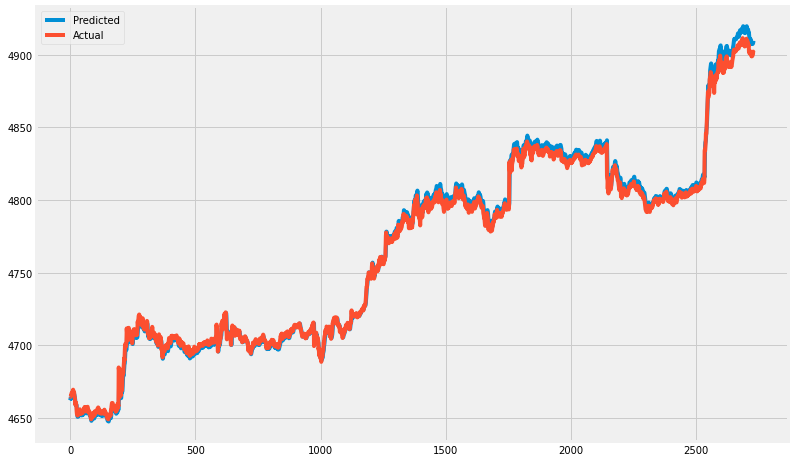

Iter:  11 train:  0.008519533112667 val:  0.010940360443442647
Iter:  12 train:  0.008820407685586376 val:  0.00968857306754483
Iter:  13 train:  0.008264971684711466 val:  0.010683845906998373
Iter:  14 train:  0.00819021926506185 val:  0.008878391761522343
Iter:  15 train:  0.008352017577761673 val:  0.009018425502960678
Iter:  16 train:  0.007538382903614643 val:  0.008403964450811386
Iter:  17 train:  0.007797738540545118 val:  0.008522238547798345
Iter:  18 train:  0.007624371518907025 val:  0.02071068722707961
Iter:  19 train:  0.007883318823555153 val:  0.00866127014083228
Iter:  20 train:  0.007259673291154499 val:  0.0075029205038539305
Rmse:  1.9683671 mae:  1.2943367


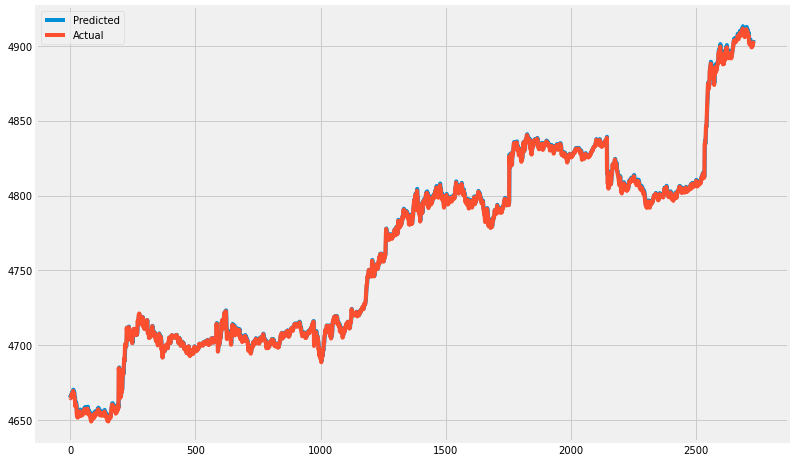

Iter:  21 train:  0.007680899427413467 val:  0.0074549686387879715
Iter:  22 train:  0.007375579242895485 val:  0.010166552040337432
Iter:  23 train:  0.007464597949753835 val:  0.008586838773605669
Iter:  24 train:  0.007921384321380441 val:  0.007423342043463611
Iter:  25 train:  0.007109991431603674 val:  0.018595114592947784
Iter:  26 train:  0.0074955870945095674 val:  0.007435344705511707
Iter:  27 train:  0.007382767741490004 val:  0.008705986359577087
Iter:  28 train:  0.0073822825210483325 val:  0.009403787489220312
Iter:  29 train:  0.007544729069705694 val:  0.010405212875042513
Iter:  30 train:  0.007711515586999095 val:  0.007644645605300028
Rmse:  2.005553 mae:  1.3220254


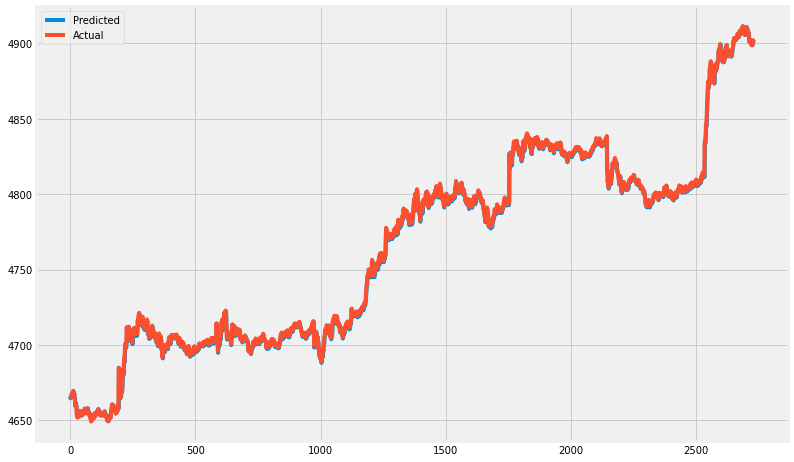

Iter:  31 train:  0.007228309126137282 val:  0.00780530111875188
Iter:  32 train:  0.007385174434618743 val:  0.007872638776916855
Iter:  33 train:  0.0070537267790548005 val:  0.0077983414487359575
Iter:  34 train:  0.007116791124095494 val:  0.007469901121801328
Iter:  35 train:  0.007113484903225667 val:  0.00717322043845179
Iter:  36 train:  0.007195559504428562 val:  0.00856520472779548
Iter:  37 train:  0.007535748030978171 val:  0.007188687001837013
Iter:  38 train:  0.007161322219455387 val:  0.00740809992587343
Iter:  39 train:  0.007054926179916887 val:  0.007497621850042919
Iter:  40 train:  0.00696483572824663 val:  0.00740597350430082
Rmse:  1.9429363 mae:  1.2737049


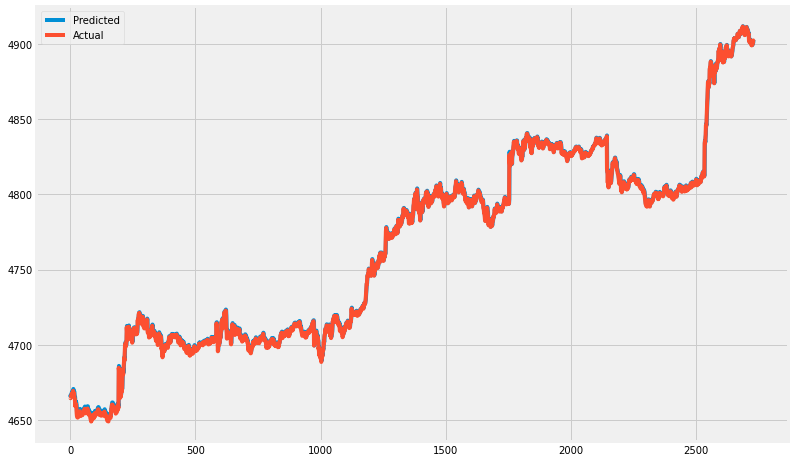

Iter:  41 train:  0.006912654829782758 val:  0.007225578206162346
Iter:  42 train:  0.006956799375610805 val:  0.007142903979156798
Iter:  43 train:  0.007446767857292603 val:  0.007419702235848706
Iter:  44 train:  0.006856857702759138 val:  0.007628441453971642
Iter:  45 train:  0.00700637137752296 val:  0.008257286152669754
Iter:  46 train:  0.0069181440546302085 val:  0.007149292312090209
Iter:  47 train:  0.006910666763832131 val:  0.007731376704675553
Iter:  48 train:  0.006948636685765592 val:  0.008215181605169252
Iter:  49 train:  0.0069935620391970935 val:  0.007801671334359801
Iter:  50 train:  0.006922783475590875 val:  0.007140113051568778
Rmse:  1.873183 mae:  1.1811341


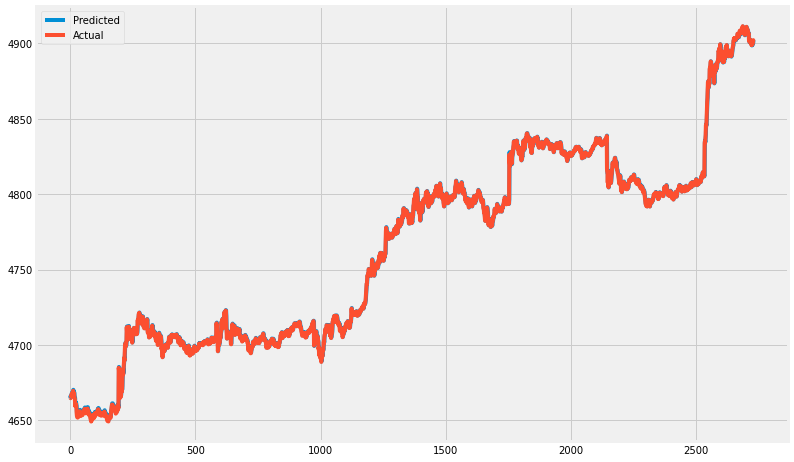

In [86]:
epochs = 51
loss = nn.MSELoss()
for i in range(epochs):
    mse_train = 0
    for X_values, y_history, y_values in data_train_loader :
        X_values = X_values.cuda()
        y_values = y_values.cuda()
        y_history = y_history.cuda()
        opt.zero_grad()
        y_pred = model(X_values, y_history)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, y_values)
        l.backward()
        mse_train += l.item()*X_values.shape[0]
        opt.step()
    scheduler.step()
    
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for X_values, y_history, y_values in data_val_loader:
            X_values = X_values.cuda()
            y_values = y_values.cuda()
            y_history = y_history.cuda()
            output = model(X_values, y_history)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(y_values.detach().cpu().numpy())
            mse_val += loss(output, y_values).item()*X_values.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Iter: ", i, "train: ", (mse_train/len(X_train))**0.5, "val: ", (mse_val/len(X_val))**0.5)
    
    if(i % 10 == 0):
        preds = preds*(max_target - min_target) + min_target
        true = true*(max_target - min_target) + min_target
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("Rmse: ", np.sqrt(mse), "mae: ", mae)
        plt.figure(figsize=(12, 8))
        plt.plot(preds,label="Predicted")
        plt.plot(true,label="Actual")
        plt.legend(loc="best")
        plt.show()


#### Testing the model

Rmse:  6.3913717 mae:  4.056078


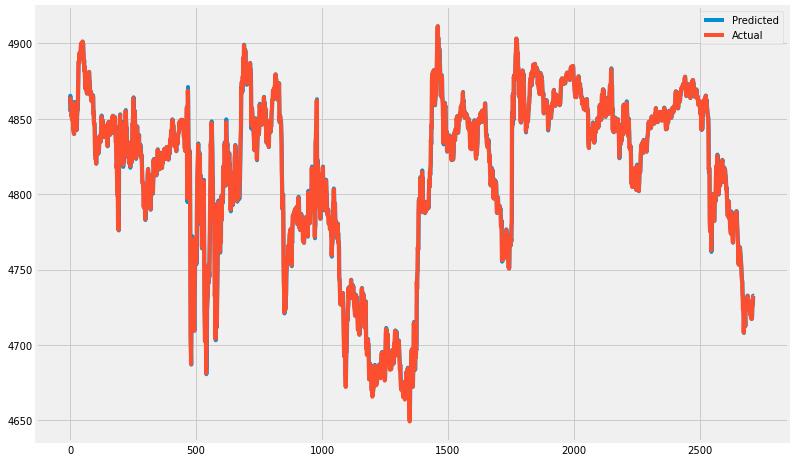

In [88]:
with torch.no_grad():
    mse_val = 0
    preds_test = []
    true_test = []
    for X_values, y_history, y_values in data_test_loader:
        X_values = X_values.cuda()
        y_values = y_values.cuda()
        y_history = y_history.cuda()
        output = model(X_values, y_history)
        preds_test.append(output.detach().cpu().numpy())
        true_test.append(y_values.detach().cpu().numpy())
        mse_val += loss(output, y_values).item()*X_values.shape[0]
preds_test = np.concatenate(preds_test)
true_test = np.concatenate(true_test)

preds_test = preds_test*(max_target - min_target) + min_target
true_test = true_test*(max_target - min_target) + min_target
mse_test = mean_squared_error(true_test, preds_test)
mae_test = mean_absolute_error(true_test, preds_test)
print("Rmse: ", np.sqrt(mse_test), "mae: ", mae_test)
plt.figure(figsize=(12, 8))
plt.plot(preds_test,label="Predicted")
plt.plot(true_test,label="Actual")
plt.legend(loc="best")
plt.show()